In [1]:
import os
import torch
import pyprobound
import pyprobound.plotting

# Data specification

In [2]:
alphabet = pyprobound.alphabets.DNA()
dataframe = pyprobound.get_dataframe(
    ["../data/CTCF_ChIP-seq/Control-R1_CTCF-R1.1000000.tsv.gz"]
)
count_table = pyprobound.CountTable(dataframe, alphabet, zero_pad=True)

# Model specification

In [3]:
nonspecific = pyprobound.layers.NonSpecific(alphabet=alphabet, name="NS")
fragmentation_psams = [
    pyprobound.layers.PSAM(
        alphabet=alphabet,
        kernel_size=10,
        name=f"Fragmentation{i}",
    )
    for i in range(5)
]
ctcf_psam = pyprobound.layers.PSAM(
    alphabet=alphabet,
    kernel_size=18,
    seed=["---CGCCMYCTAGTGG--"],
    name="CTCF",
)

In [4]:
# NS
conv0d = pyprobound.layers.Conv0d.from_nonspecific(nonspecific, count_table)
mode_ns = pyprobound.Mode([conv0d])

# LeftFragmentation
roll_left = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(
        alphabet, direction="left", max_length=10, include_n=True
    ),
    count_table,
)
conv1ds_left = [
    pyprobound.layers.Conv1d.from_psam(
        psam, roll_left, out_channel_indexing=[0]
    )
    for psam in fragmentation_psams
]
modes_left = [
    pyprobound.Mode([roll_left, conv1d_left]) for conv1d_left in conv1ds_left
]

# RightFragmentation
roll_right = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(
        alphabet, direction="right", max_length=10, include_n=True
    ),
    count_table,
)
conv1ds_right = [
    pyprobound.layers.Conv1d.from_psam(
        psam, roll_right, out_channel_indexing=[1]
    )
    for psam in fragmentation_psams
]
modes_right = [
    pyprobound.Mode([roll_right, conv1d_right])
    for conv1d_right in conv1ds_right
]

# CTCF
roll_center = pyprobound.layers.Roll.from_spec(
    pyprobound.layers.RollSpec(alphabet, direction="center", include_n=True),
    count_table,
)
conv1d = pyprobound.layers.Conv1d.from_psam(
    ctcf_psam,
    roll_center,
    train_posbias=True,
    bias_bin=5,
    length_specific_bias=False,
    bias_mode="same",
)
mode_ctcf = pyprobound.Mode([roll_center, conv1d])

In [5]:
order = [
    [mode_ns.key()],
    *zip([i.key() for i in modes_left], [i.key() for i in modes_right]),
    [mode_ctcf.key()],
]
round_initial = pyprobound.rounds.InitialRound()
reference_round = round_initial
for mode_left, mode_right in zip(modes_left, modes_right):
    round_left = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
        [mode_ns, mode_left],
        reference_round,
        activity_heuristic=0.1,
        train_depth=False,
    )
    round_right = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
        [mode_ns, mode_right],
        round_left,
        activity_heuristic=0.1,
        train_depth=False,
    )
    reference_round = round_right
round_bound = pyprobound.rounds.BoundUnsaturatedRound.from_binding(
    [mode_ns, mode_ctcf], reference_round, activity_heuristic=0.1
)
experiment = pyprobound.Experiment(
    [round_initial, round_bound],
    counts_per_round=count_table.counts_per_round,
)
model = pyprobound.MultiExperimentLoss([experiment], full_loss=True)

# Fitting

In [6]:
optimizer = pyprobound.Optimizer(
    model,
    [count_table],
    greedy_threshold=0,
    device="cpu",
    optim_args={"max_iter": 500},
    checkpoint="CTCF_ChIP-seq_end5.pt",
    output="CTCF_ChIP-seq_end5.txt",
)

In [7]:
print(optimizer.get_train_sequential(order=order))

### Binding: NSNonSpecific
	Step 0
		MultiExperimentLoss.freeze()
		0thExperiment→1stBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→1stBoundUnsaturatedRound→Aggregate→0thContribution)
		0thExperiment→1stBoundUnsaturatedRound.unfreeze(parameter=depth)
		0thExperiment→2ndBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→2ndBoundUnsaturatedRound→Aggregate→0thContribution)
		0thExperiment→2ndBoundUnsaturatedRound.unfreeze(parameter=depth)
		0thExperiment→3rdBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→3rdBoundUnsaturatedRound→Aggregate→0thContribution)
		0thExperiment→3rdBoundUnsaturatedRound.unfreeze(parameter=depth)
		0thExperiment→4thBoundUnsaturatedRound→Aggregate.activity_heuristic(contribution=0thExperiment→4thBoundUnsaturatedRound→Aggregate→0thContribution)
		0thExperiment→4thBoundUnsaturatedRound.unfreeze(parameter=depth)
		0thExperiment→5thBoundUnsaturatedRound→Aggregate.activity_heuristic(

In [8]:
if os.path.exists(optimizer.output):
    os.remove(optimizer.output)
optimizer.train_sequential(order=order)

tensor(1.6365)

In [9]:
optimizer.reload()

{'time': 'Mon Nov 27 18:33:49 2023',
 'version': '1.0.0',
 'flank_lengths': ((0, 0),)}

In [10]:
# fmt: off
ctcf_psam.save("CTCF_ChIP-seq_end5-ctcf_psam.pt", ((0,0,)))
# fmt: on

# Loss

In [11]:
with torch.inference_mode():
    loss, reg = model([count_table])
    print(loss, reg, loss + reg)

tensor(1.6360) tensor(0.0005) tensor(1.6365)


# Logo

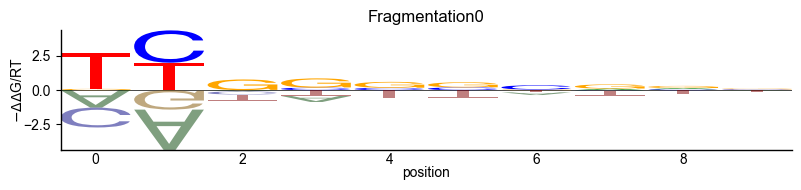

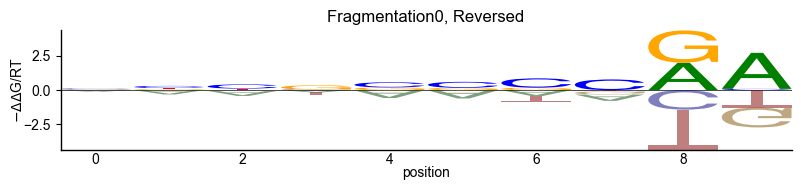

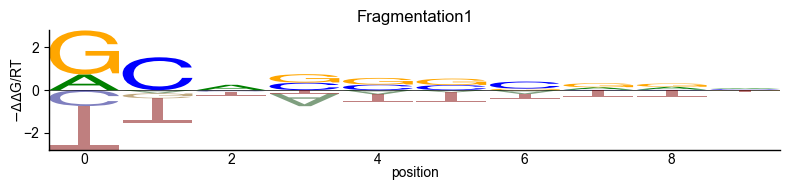

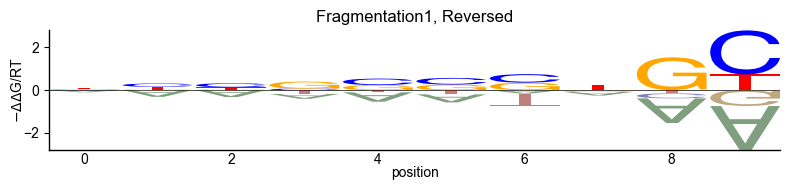

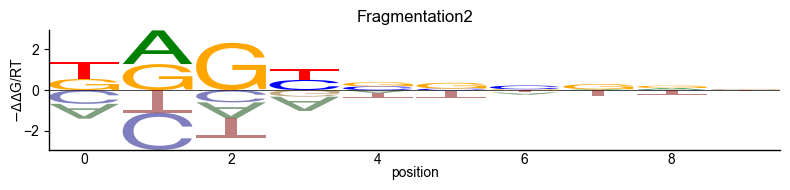

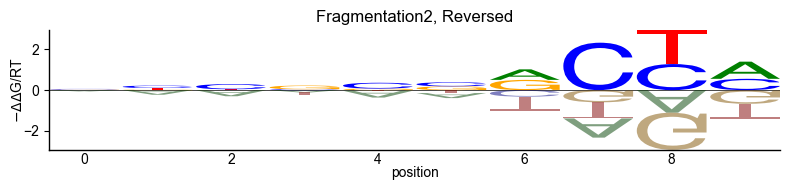

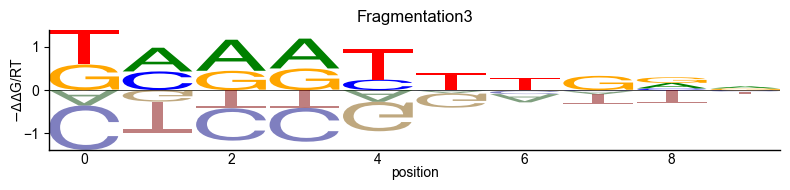

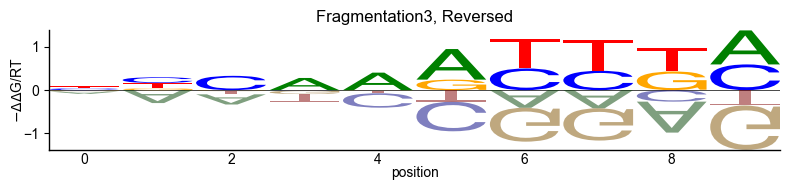

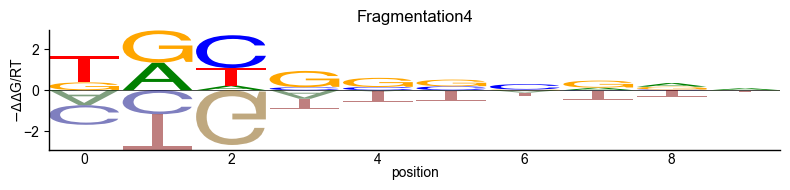

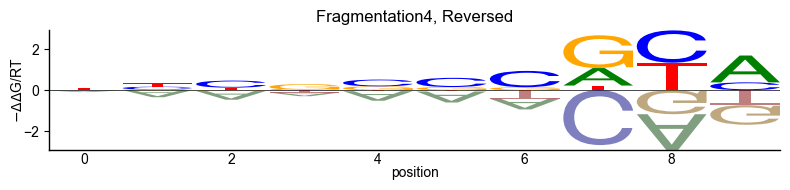

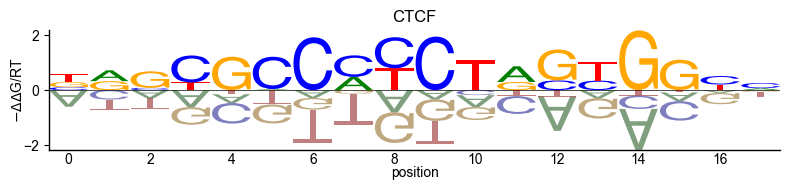

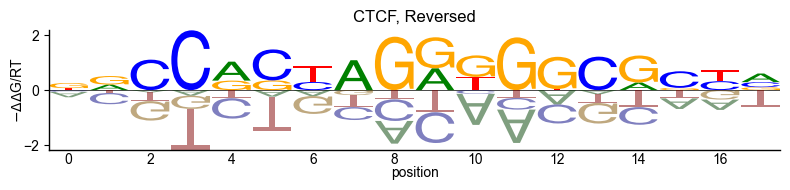

In [12]:
for psam in fragmentation_psams + [ctcf_psam]:
    pyprobound.plotting.logo(psam)
    pyprobound.plotting.logo(psam, reverse=True)

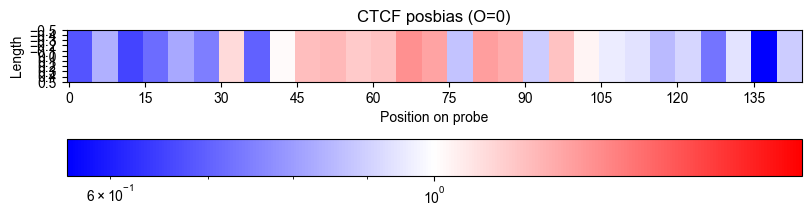

In [13]:
pyprobound.plotting.posbias(mode_ctcf.layers[1])

# Probe enrichment

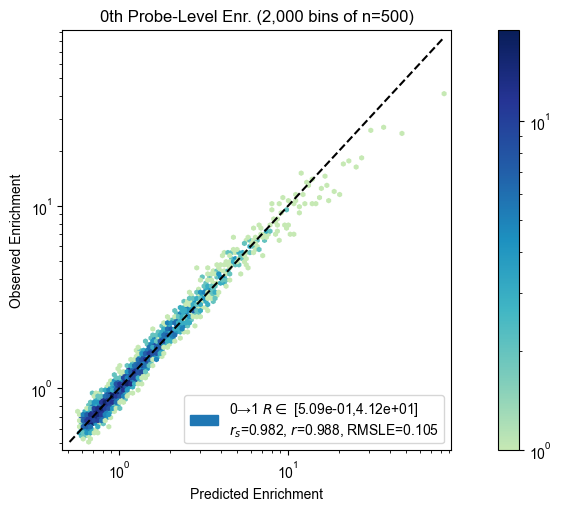

In [14]:
pyprobound.plotting.probe_enrichment(experiment, count_table)

# Mode contribution

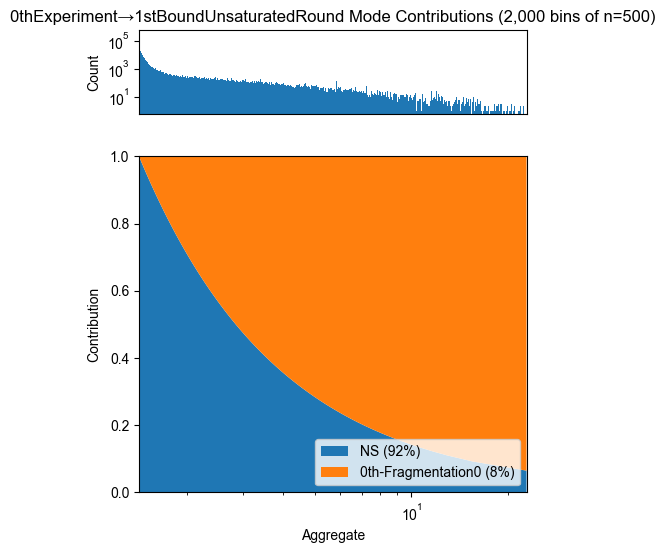

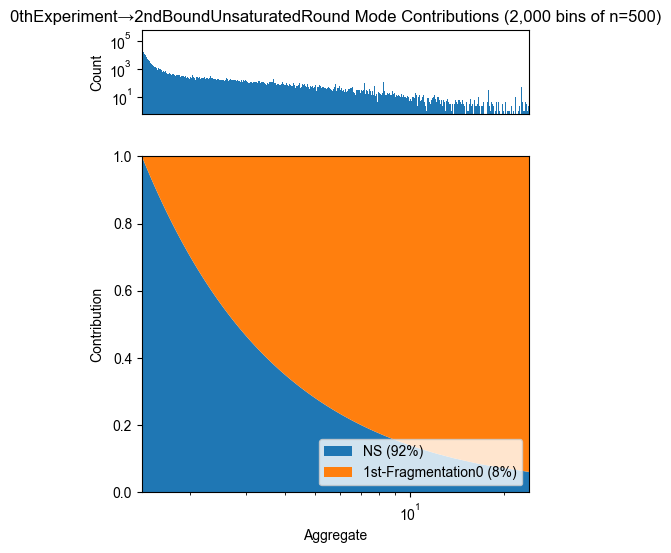

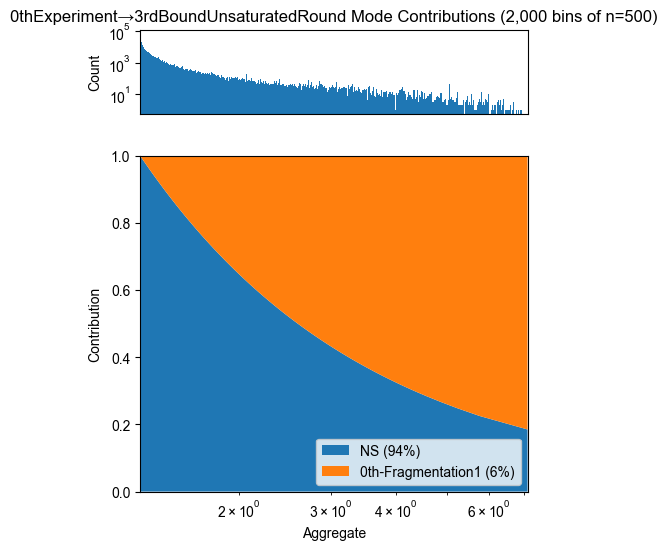

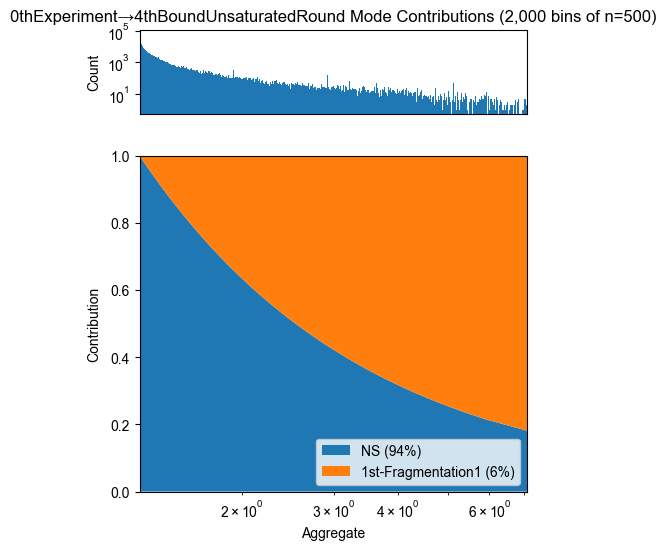

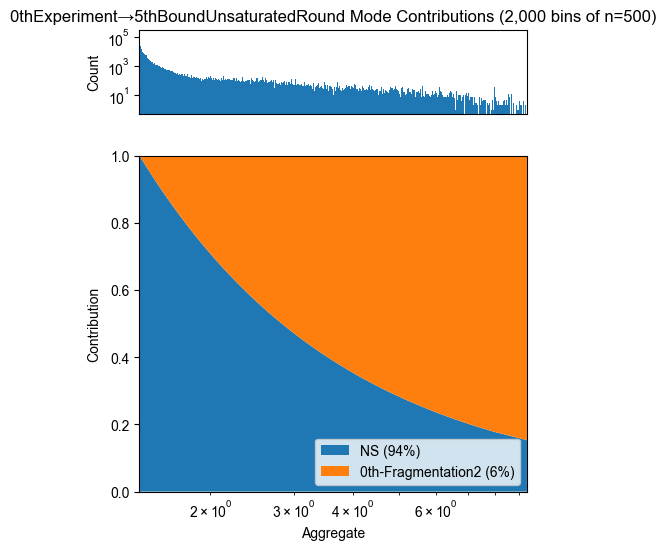

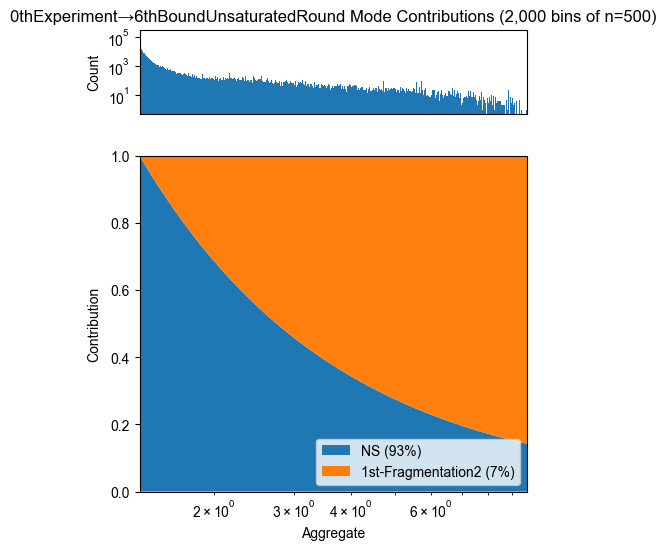

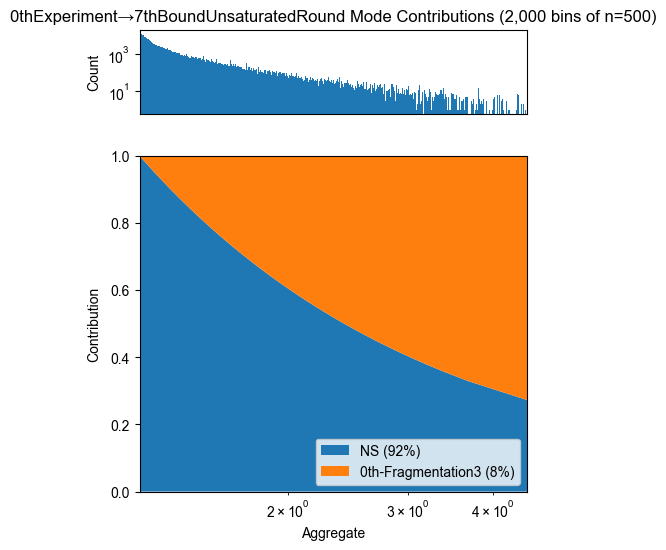

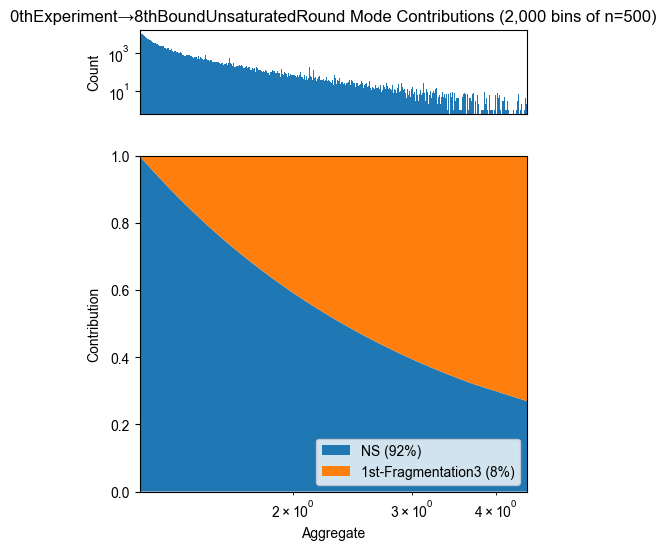

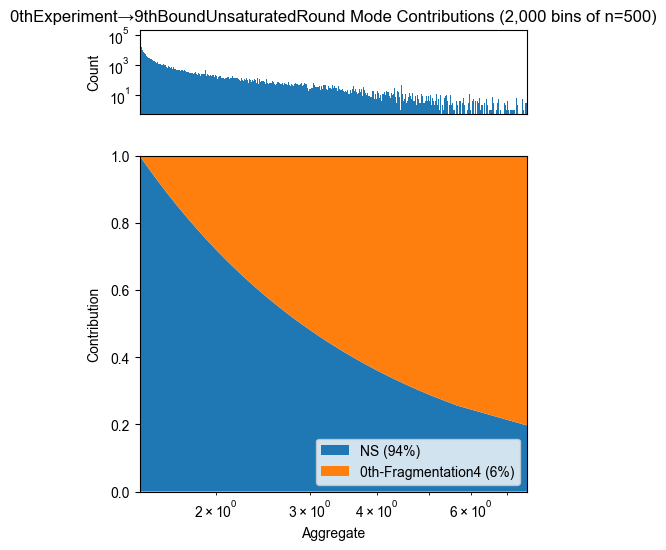

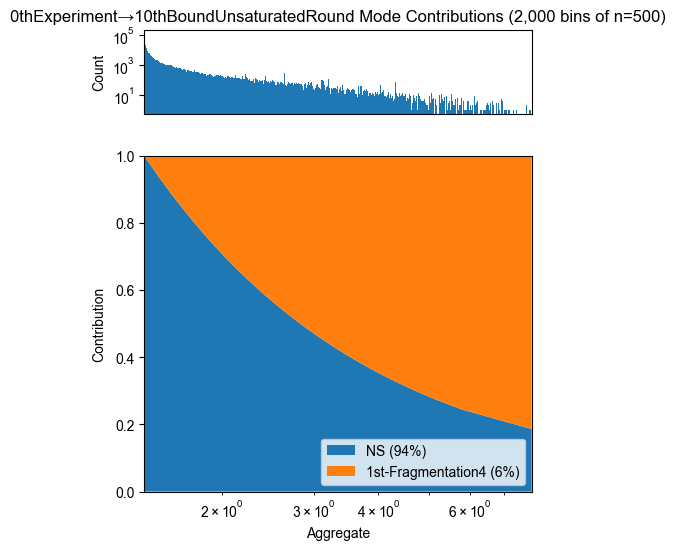

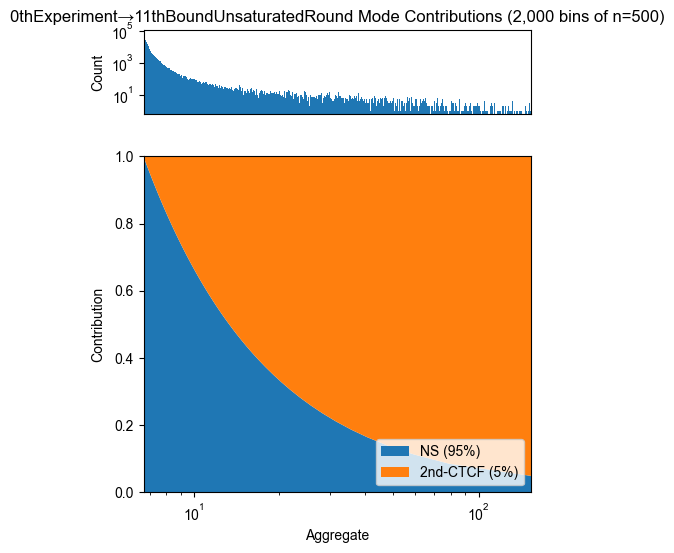

In [15]:
for rnd in experiment.rounds[1:]:
    pyprobound.plotting.contribution(rnd, count_table)